# GBGPU Tutorial

`GBGPU` is a GPU-accelerated version of the `FastGB` waveform which has been developed by Neil Cornish, Tyson Littenberg, Travis Robson, and Stas Babak. It computes gravitational waveforms for Galactic binary systems observable by LISA using a fast/slow-type decomposition. For more details on the original construction of `FastGB` see [arXiv:0704.1808](https://arxiv.org/abs/0704.1808).

The current version of the code is very closely related to the implementation of `FastGB` in the LISA Data Challenges' Python code package. The waveform code is entirely Python-based. It is about 1/2 the speed of the full C version, but much simpler in Python for right now. There are also many additional functions including fast likelihood computations for individual Galactic binaries, as well as fast C-based methods to combine waveforms into global fitting templates. 

The code is CPU/GPU agnostic. CUDA and NVIDIA GPUs are required to run these codes for GPUs.

See the [documentation](https://mikekatz04.github.io/GBGPU/html/index.html) for more details. This code was designed for (# TODO: add new arxiv number). If you use any part of this code, please cite (# TODO: add new arxiv number), its Zenodo page (# TODO: add zenodo page), [arXiv:0704.1808](https://arxiv.org/abs/0704.1808), and [arXiv:1806.00500](https://arxiv.org/abs/1806.00500). 

In [17]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

from gbgpu.gbgpu import GBGPU

from gbgpu.utils.constants import *

## Generated Galactic binary waveforms

Initialize the waveform class.

In [18]:
gb = GBGPU(use_gpu=False)

Setup all the binary information. GBGPU operates in a vectorized manner, so it takes arrays of parameters as inputs.

In [19]:
dt = 10.0
Tobs = 4.0 * YEAR


# number of points in waveform
# if None, will determine inside the code based on amp, f0 (and P2 if running third-body waveform)
N = None

# number of binaries to batch
num_bin = 10

# parameters
amp = 2e-23  # amplitude
f0 = 2e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 ## not included (place holder for future?)
phi0 = 0.1  # initial phase
iota = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude


# for batching
amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)


Generate the waveforms.

signal length: (512,)


(0.0019993, 0.0020007000000000002)

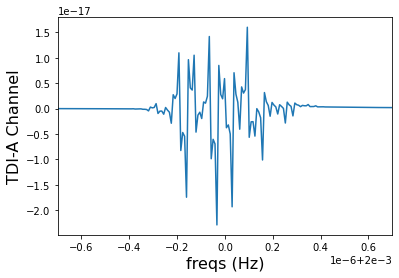

In [20]:
%matplotlib  inline
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

# can also use a 2D array of 
# np.asarray([amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,])

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A = gb.A[0]
freqs = gb.freqs[0]
print("signal length:", A.shape)
plt.plot(freqs, A.real)
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx)

### Add a third-body

In [25]:
A2 = 100.0  # third body amplitude parameter
varpi = 1.0  # varpi phase parameter
e2 = 0.3  # eccentricity of third body
P2 = 1.2  # period of third body
T2 = 0.5 * P2  # time of periapsis passage of third body


A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
varpi_in = np.full(num_bin, varpi)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

Third-body signal length: (512,)


(0.0019993, 0.0020007000000000002)

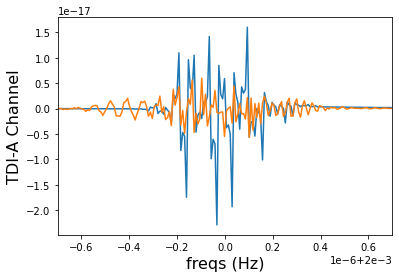

In [26]:
%matplotlib  inline
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in, A2_in, varpi_in, e2_in, P2_in, T2_in]
)

gb.run_wave(*params, N=N, dt=dt, T=Tobs, oversample=2)

# signal from first binary
A_third = gb.A[0]
freqs = gb.freqs[0]
print("Third-body signal length:", A_third.shape)
plt.plot(freqs, A.real, label="No third body")
plt.plot(freqs, A_third.real, label="No third body")
plt.ylabel("TDI-A Channel", fontsize=16)
plt.xlabel("freqs (Hz)", fontsize=16)
dx = 7e-7
plt.xlim(f0 - dx, f0 + dx)

## Circular Galactic Binary

In [ ]:
# prepare fake data for likelihood calculation
freqs = np.fft.rfftfreq(length, dt)
data_stream_length = len(freqs)

data = [
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
    1e-24 * np.ones(data_stream_length, dtype=np.complex128),
]

noise_factor = [
    np.ones(data_stream_length, dtype=np.float64),
    np.ones(data_stream_length, dtype=np.float64),
]


In [ ]:
params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

num = 100

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


In [ ]:
plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))


params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_ecc, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

# zoom in on j = 3 mode
plt.plot(gb.freqs[2][0], np.abs(gb.A[2][0]))

params_circ_third = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        A2_in,
        varpi_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    varpi,
    e2,
    P2,
    T2,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(
        params_circ_third, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
    )
et = time.perf_counter()
print("circ / third:", (et - st) / num, "per binary:", (et - st) / (num * num_bin))


plt.plot(gb.freqs[0][0], np.abs(gb.A[0][0]))

params_full = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
        A2_in,
        varpi_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    A2,
    varpi,
    e2,
    P2,
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

st = time.perf_counter()
for _ in range(num):
    like = gb.get_ll(params_full, [A_inj, E_inj], noise_factor, N=N, dt=dt, modes=modes, T=Tobs,)
et = time.perf_counter()
print(
    "ecc/third ({} modes):".format(len(modes)),
    (et - st) / num,
    "per binary:",
    (et - st) / (num * num_bin),
)


for i in range(len(modes)):
    plt.plot(gb.freqs[i][0], np.abs(gb.A[i][0]))

In [ ]:
df = 1/(Tobs) 
fmax = 1e-2
noise_freqs = np.arange(0.0, fmax, df)

AE_noise = tdi.noisepsd_AE(noise_freqs)

noise_factor = [1/np.sqrt(AE_noise) * np.sqrt(df), 1/np.sqrt(AE_noise) * np.sqrt(df)]

In [ ]:
%matplotlib qt
plt.loglog(noise_freqs, AE_noise)
plt.plot(gb.freqs[0][0], 2 * 1/Tobs * np.abs(gb.A[0][0])**2)
#plt.xlim(0.0019989808400472007, 0.002001007397969564)

# inject eccentric signal

params_ecc = np.array(
    [
        amp_in,
        f0_in,
        fdot_in,
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        e1_in,
        beta1_in,
    ]
)

modes = np.array([1, 2, 3, 4])
A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    e1,
    beta1,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]  # right summation rule

# try to extract with ecc

like = gb.get_ll(
    params_ecc, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('ecc template log likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

print('circ template log likelihood:', like)

# inject circular with eccentric third body

A_inj, E_inj = gb.inject_signal(
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    varpi,
    e2, 
    P2, 
    T2,
    modes=modes,
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]  # right summation rule

# try to extract with circular third body

like = gb.get_ll(
    params_circ_third, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_third = gb.A[0][0].copy()
freqs_third = gb.freqs[0][0].copy()

print('circular third body template likelihood:', like)

# try to extract with circular

params_circ = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)

like = gb.get_ll(
    params_circ, data, noise_factor, N=N, dt=dt, modes=np.array([2]), T=Tobs,
)

A_circ = gb.A[0][0].copy()

freqs_circ = gb.freqs[0][0].copy()

print('circ template likelihood:', like)

## Fisher

num_bin = 100
amp = 1e-19
f0 = 2e-3
fdot = 1e-14
fddot = 0.0
phi0 = 0.1
iota = 0.2
psi = 0.3
lam = 0.4
beta_sky = 0.5
A2 = 19.5
varpi = 0.0
e2 = 0.3
P2 = 0.6
T2 = 0.0

amp_in = np.full(num_bin, amp)
f0_in = np.full(num_bin, f0)
fdot_in = np.full(num_bin, fdot)
fddot_in = np.full(num_bin, fddot)
phi0_in = np.full(num_bin, phi0)
iota_in = np.full(num_bin, iota)
psi_in = np.full(num_bin, psi)
lam_in = np.full(num_bin, lam)
beta_sky_in = np.full(num_bin, beta_sky)
A2_in = np.full(num_bin, A2)
P2_in = np.full(num_bin, P2)
varpi_in = np.full(num_bin, varpi)
e2_in = np.full(num_bin, e2)
T2_in = np.full(num_bin, T2)

N = int(1024)

Tobs = 4.0 * YEAR
dt = 15.0

waveform_kwargs = dict(N=N, dt=dt, T=Tobs)

# ln (amp), f0 in ms, ln (fdot)
transform_fn = {
    0: np.exp,
    1: (lambda x: x * 1e-3),
    2: np.exp,
}

injection_params = np.array(
    [
        np.log(amp),
        f0 * 1e3,
        fdot,
        fddot,
        phi0,
        iota,
        psi,
        lam,
        beta_sky,
        A2,
        varpi,
        e2,
        P2,
        T2,
    ]
)

fish_params = np.array(
    [
        np.log(amp_in),
        f0_in * 1e3,
        np.log(fdot_in),
        fddot_in,
        phi0_in,
        iota_in,
        psi_in,
        lam_in,
        beta_sky_in,
        A2_in,
        varpi_in,
        e2_in,
        P2_in,
        T2_in,
    ]
)

inds_test = np.delete(np.arange(len(fish_params)), 3)
fish = gb.fisher(
    fish_params, inds=inds_test, parameter_transforms=transform_fn, **waveform_kwargs
)

fish

fish[0]

fish[0].diagonal()

cov = np.linalg.pinv(fish[0])

np.sqrt(cov.diagonal()) # standard deviation

## emcee example

In [ ]:
from scipy.stats import uniform

def uniform_dist(min, max):
    if min > max:
        temp = min
        min = max
        max = temp

    mean = (max + min) / 2.0
    sig = max - min
    dist = uniform(min, sig)
    return dist

In [ ]:
df = 1/(Tobs) # not exactly right
fmax = 1e-2
noise_freqs = np.arange(0.0, fmax, df)

AE_noise = tdi.noisepsd_AE(noise_freqs)

noise_factor = [1/np.sqrt(AE_noise) * np.sqrt(df), 1/np.sqrt(AE_noise) * np.sqrt(df)]

injection_params = np.array([
    amp,
    f0,
    fdot,
    fddot,
    phi0,
    iota,
    psi,
    lam,
    beta_sky,
    A2,
    varpi,
    e2, 
    P2, 
    T2,
])
A_inj, E_inj = gb.inject_signal(
    *injection_params,
    modes=np.array([2]),
    N=N,
    dt=dt,
    T=Tobs,
)

A_inj = A_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)
E_inj = E_inj[:len(AE_noise)] / np.sqrt(AE_noise) * np.sqrt(df)

data = [A_inj, E_inj]

In [ ]:
priors = [
    uniform_dist(amp * 0.95, amp * 1.05),
    uniform_dist(f0 * 0.95, f0 * 1.05),
    uniform_dist(fdot * 0.95, fdot * 1.05),
    uniform_dist(fddot * 0.95, fddot * 1.05),
    uniform_dist(0.0, 2 * np.pi),
    uniform_dist(0.0, np.pi),
    uniform_dist(0.0, np.pi),
    uniform_dist(0.0, 2 * np.pi),
    uniform_dist(-np.pi/2, np.pi/2.),
    uniform_dist(A2 * 0.95, A2 * 1.05),
    uniform_dist(0.0, 0.5),
    uniform_dist(e2 * 0.95, e2 * 1.05),
    uniform_dist(P2 * 0.95, P2 * 1.05),
    uniform_dist(0.0, 1.0),
]

In [ ]:
class Likelihood:
    def __init__(self, lnlike, priors, data, noise_factor, N, dt, modes, Tobs):
        self.priors = priors
        self.lnlike = lnlike
        self.data = data
        self.noise_factor = noise_factor
        self.N, self.dt, self.modes, self.Tobs = N, dt, modes, Tobs
        
    def __call__(self, x):
        prior_vals = np.zeros((x.shape[0]))
        for prior_i, x_i in zip(self.priors, x.T):
            temp = prior_i.logpdf(x_i)

            prior_vals[np.isinf(temp)] += -np.inf
            
        inds_eval = np.atleast_1d(np.squeeze(np.where(np.isinf(prior_vals) != True)))

        loglike_vals = np.full(x.shape[0], -np.inf)

        if len(inds_eval) == 0:
            return np.array([-loglike_vals, prior_vals]).T

        temp = self.lnlike.get_ll(
            x[inds_eval].T, self.data, self.noise_factor, N=self.N, dt=self.dt, modes=self.modes, T=self.Tobs,
        )

        loglike_vals[inds_eval] = temp

        return np.array([loglike_vals, prior_vals]).T

In [ ]:
like = Likelihood(gb, priors, data, noise_factor, N, dt, np.array([2]), Tobs)

In [ ]:
ndim = len(injection_params)
nwalkers = 100

test_x = np.tile(injection_params, (nwalkers, 1))

print(like(test_x))

In [ ]:
factor = 1e-8
start_points = test_x * (1 + factor * np.random.randn(nwalkers, ndim))
inds = np.where(start_points == 0.0)

start_points[inds] = np.abs(factor * np.random.randn(nwalkers, ndim))[inds]
print(like(start_points))

In [ ]:
sampler = emcee.EnsembleSampler(
            nwalkers,
            ndim,
            like,
            vectorize=True,
        )

In [ ]:
nsteps = 1000
sampler.reset()
sampler.run_mcmc(start_points, nsteps, progress=True)

In [ ]:
samples = sampler.get_chain(flat=True)

In [ ]:
import corner
corner.corner(samples)